<a href="https://colab.research.google.com/github/roy056/Test/blob/main/Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyedflib scikit-learn xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2734951 sha256=a5926a6321b0008eeb4cc276e9ca116b836c03b1c1d970bd56dd76dc88eb7efb
  Stored in directory: /root/.cache/pip/wheels/8d/df/d6/88ce619bde055ebffebae5380645802eca490817853b60b45b
Successfully built pyedflib


_*Installed the libraries, now upzippin the dataset*_

In [ ]:
!unzip eeg-during-mental-arithmetic-tasks-1.0.0.zip

Archive:  eeg-during-mental-arithmetic-tasks-1.0.0.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of eeg-during-mental-arithmetic-tasks-1.0.0.zip or
        eeg-during-mental-arithmetic-tasks-1.0.0.zip.zip, and cannot find eeg-during-mental-arithmetic-tasks-1.0.0.zip.ZIP, period.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving eeg-during-mental-arithmetic-tasks-1.0.0.zip to eeg-during-mental-arithmetic-tasks-1.0.0 (1).zip


_*Uploaded the zip files, now unzip*_

In [5]:
!unzip eeg-during-mental-arithmetic-tasks-1.0.0.zip

Archive:  eeg-during-mental-arithmetic-tasks-1.0.0.zip
   creating: eeg-during-mental-arithmetic-tasks-1.0.0/
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/README.txt  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/RECORDS  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/SHA256SUMS.txt  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/subject-info.csv  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_1.edf  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_2.edf  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_1.edf  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_2.edf  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/Subject03_1.edf  
  inflating: eeg-during-mental-arithmetic-tasks-1.0.0/Subject03_2.edf  
  inflating: eeg-during-mental-arithmet

Verifying the files

In [6]:
!ls eeg-during-mental-arithmetic-tasks-1.0.0

README.txt	 Subject06_2.edf  Subject14_2.edf  Subject22_2.edf  Subject30_2.edf
RECORDS		 Subject07_1.edf  Subject15_1.edf  Subject23_1.edf  Subject31_1.edf
SHA256SUMS.txt	 Subject07_2.edf  Subject15_2.edf  Subject23_2.edf  Subject31_2.edf
Subject00_1.edf  Subject08_1.edf  Subject16_1.edf  Subject24_1.edf  Subject32_1.edf
Subject00_2.edf  Subject08_2.edf  Subject16_2.edf  Subject24_2.edf  Subject32_2.edf
Subject01_1.edf  Subject09_1.edf  Subject17_1.edf  Subject25_1.edf  Subject33_1.edf
Subject01_2.edf  Subject09_2.edf  Subject17_2.edf  Subject25_2.edf  Subject33_2.edf
Subject02_1.edf  Subject10_1.edf  Subject18_1.edf  Subject26_1.edf  Subject34_1.edf
Subject02_2.edf  Subject10_2.edf  Subject18_2.edf  Subject26_2.edf  Subject34_2.edf
Subject03_1.edf  Subject11_1.edf  Subject19_1.edf  Subject27_1.edf  Subject35_1.edf
Subject03_2.edf  Subject11_2.edf  Subject19_2.edf  Subject27_2.edf  Subject35_2.edf
Subject04_1.edf  Subject12_1.edf  Subject20_1.edf  Subject28_1.edf  subject-info.csv
Subj

_*Now changing the base path*_

In [7]:
base_path = "/content/eeg-during-mental-arithmetic-tasks-1.0.0"

***Data Preperation & Feature Extraction***

In [11]:
import pyedflib
import numpy as np
from scipy import signal
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def read_edf_channels(file_path):
    with pyedflib.EdfReader(file_path) as f:
        channel_names = [ch.replace('EEG ', '') for ch in f.getSignalLabels()]
        sample_freqs = f.getSampleFrequencies()
        signals_data = [f.readSignal(i) for i in range(len(channel_names))]
    return signals_data, channel_names, sample_freqs

def compute_power_spectrum(signal_data, sample_freq):
    frequencies, psd = signal.welch(signal_data, sample_freq, nperseg=sample_freq)
    mask = (frequencies >= 0) & (frequencies <= 14)
    return frequencies[mask], psd[mask]

def compute_band_power(psd, freq):
    bands = [(i, i+2) for i in range(0, 14, 2)]
    band_power = []
    for low, high in bands:
        mask = (freq >= low) & (freq < high)
        band_power.append(np.mean(psd[mask]))
    return band_power

def extract_features(file_path):
    signals_data, channel_names, sample_freqs = read_edf_channels(file_path)
    features = []
    electrode_names = []

    for signal, name, freq in zip(signals_data, channel_names, sample_freqs):
        # Skip A1-A1 and ECG-ECG electrodes
        if name not in ['A1-A1', 'ECG-ECG']:
            freq, psd = compute_power_spectrum(signal, freq)
            band_power = compute_band_power(psd, freq)
            features.extend(band_power)
            electrode_names.append(name)

    return np.array(features), electrode_names

def prepare_dataset(base_path):
    X = []
    y = []
    electrode_names = []

    for subject in range(36):
        for condition in [1, 2]:
            file_path = os.path.join(base_path, f"Subject{subject:02d}_{condition}.edf")
            features, names = extract_features(file_path)
            X.append(features)
            y.append(condition - 1)  # 0 for no arithmetic, 1 for arithmetic
            if not electrode_names:
                electrode_names = names

    return np.array(X), np.array(y), electrode_names

# Set the base path to your dataset
base_path = "/content/eeg-during-mental-arithmetic-tasks-1.0.0"

# Prepare the dataset
X, y, electrode_names = prepare_dataset(base_path)

# Create feature names
freq_bands = ["0-2 Hz", "2-4 Hz", "4-6 Hz", "6-8 Hz", "8-10 Hz", "10-12 Hz", "12-14 Hz"]
feature_names = [f"{e}, {f}" for e in electrode_names for f in freq_bands]

print("Dataset prepared successfully!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Number of electrodes: {len(electrode_names)}")
print(f"Electrodes: {electrode_names}")
print(f"Total features: {len(feature_names)}")

# Verify we have the expected shape (72, 133)
expected_shape = (72, 19 * 7)  # 72 samples, 19 electrodes, 7 frequency bands
if X.shape == expected_shape:
    print(f"\nMatrix has the expected shape: {X.shape}")
else:
    print(f"\nWarning: Matrix shape {X.shape} differs from expected shape {expected_shape}")
    print("This could be due to a different number of electrodes in the dataset.")

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the matrices for later use
np.save('X_matrix.npy', X_scaled)
np.save('y_matrix.npy', y)
np.save('feature_names.npy', np.array(feature_names, dtype=object))

print("\nMatrices saved as 'X_matrix.npy', 'y_matrix.npy', and 'feature_names.npy'")

Dataset prepared successfully!
X shape: (72, 147)
y shape: (72,)
Number of electrodes: 21
Electrodes: ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T3', 'T4', 'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz', 'A2-A1', 'ECG ECG']
Total features: 147

This could be due to a different number of electrodes in the dataset.

Matrices saved as 'X_matrix.npy', 'y_matrix.npy', and 'feature_names.npy'


***Utility Functions for Model Evaluation and Visualization***

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

def select_best_features(X, y, k=5):
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    return X_selected, selected_indices

def evaluate_classifier(X, y, classifier, name, feature_names):
    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')

    print(f"{name} 5-Fold Cross-Validation Results:")
    print(f"Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Fit the model on the entire dataset
    classifier.fit(X, y)

    # Make predictions
    y_pred = classifier.predict(X)

    # Calculate accuracy for the entire dataset
    accuracy = accuracy_score(y, y_pred)
    print(f"\n{name} Accuracy on entire dataset: {accuracy:.4f}")

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y, y_pred, target_names=['No Arithmetic', 'Arithmetic']))

    # Print confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute feature importance
    perm_importance = permutation_importance(classifier, X, y, n_repeats=10, random_state=42)
    feature_importance = perm_importance.importances_mean

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.title(f"{name} Feature Importance", fontsize=16)
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.tight_layout()
    plt.show()

    return classifier, feature_importance

def plot_top_features(X, feature_names, top_indices, classifier_name):
    if len(top_indices) >= 2:
        # Get the top 2 features
        top1_idx = top_indices[0]
        top2_idx = top_indices[1]

        # Extract the feature values
        x_values = X[:, top1_idx]
        y_values = X[:, top2_idx]

        # Create a scatter plot
        plt.figure(figsize=(10, 8))
        plt.scatter(x_values, y_values, alpha=0.7)
        plt.xlabel(feature_names[top1_idx], fontsize=14)
        plt.ylabel(feature_names[top2_idx], fontsize=14)
        plt.title(f"{classifier_name}: Top 2 Features", fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add a trend line
        z = np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        plt.plot(x_values, p(x_values), "r--", alpha=0.7)

        plt.tight_layout()
        plt.show()

        print(f"Top feature: {feature_names[top1_idx]}")
        print(f"Second top feature: {feature_names[top2_idx]}")
    else:
        print("Not enough features to plot")

**KNN**

Running KNN Classifier...

Top 5 features selected for KNN:
Fp1, 4-6 Hz
P4, 6-8 Hz
O1, 6-8 Hz
O2, 6-8 Hz
Pz, 6-8 Hz
KNN 5-Fold Cross-Validation Results:
Accuracy: 0.6676 (+/- 0.1257)

KNN Accuracy on entire dataset: 0.7778

KNN Classification Report:
               precision    recall  f1-score   support

No Arithmetic       0.73      0.89      0.80        36
   Arithmetic       0.86      0.67      0.75        36

     accuracy                           0.78        72
    macro avg       0.79      0.78      0.78        72
 weighted avg       0.79      0.78      0.77        72



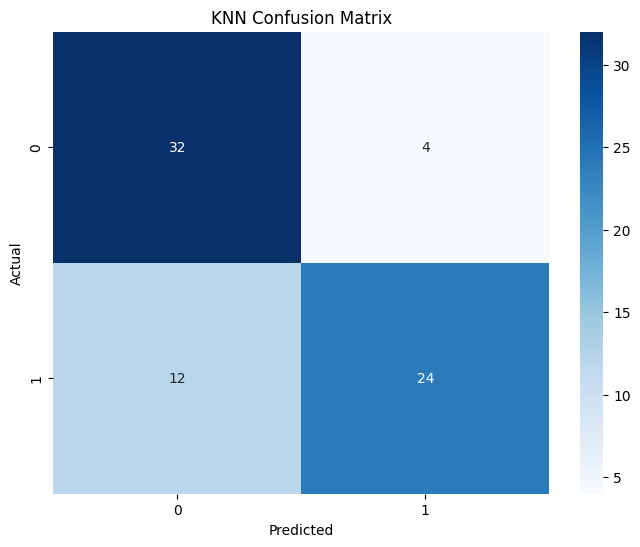

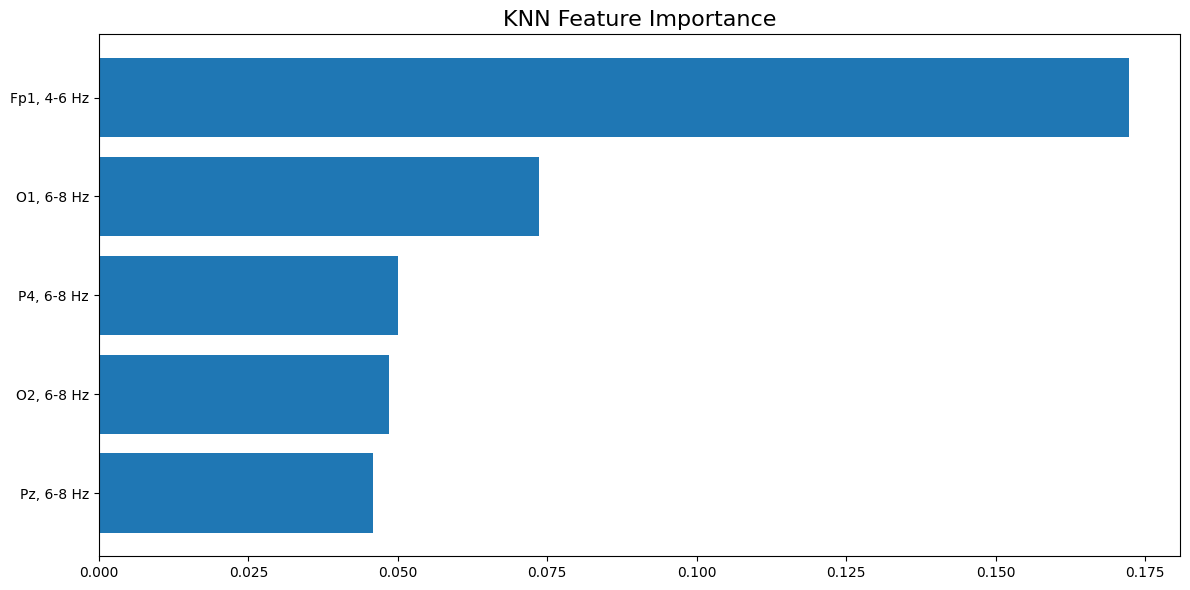

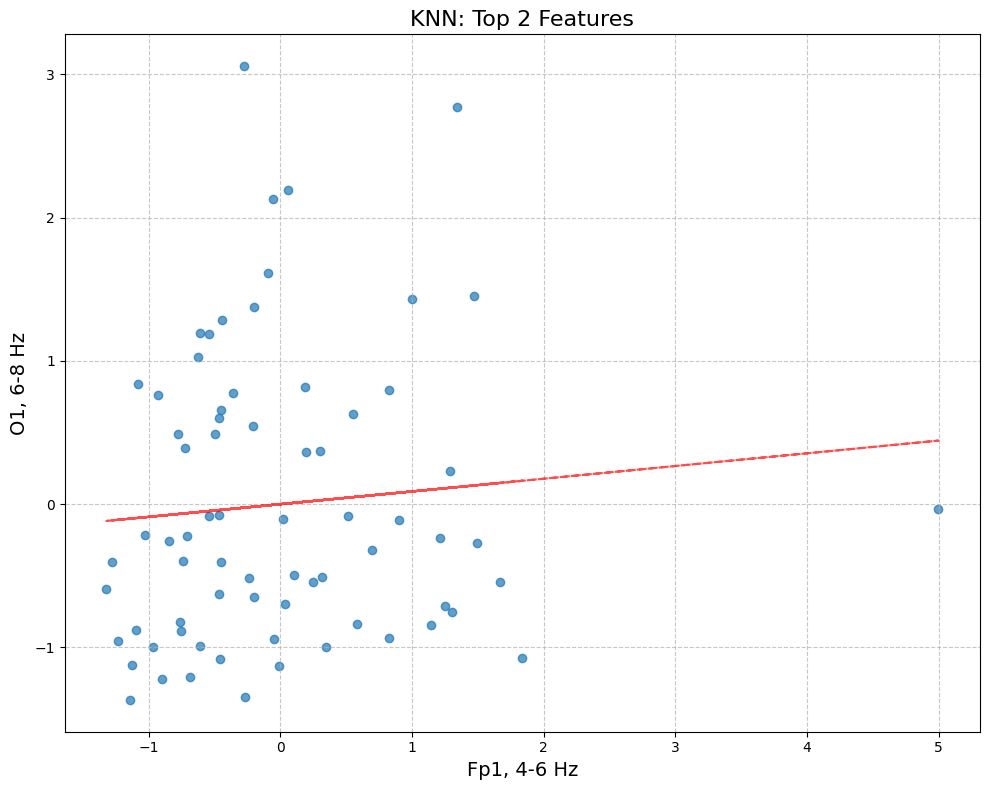

Top feature: Fp1, 4-6 Hz
Second top feature: O1, 6-8 Hz


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

# Utility functions
def select_best_features(X, y, k=5):
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    return X_selected, selected_indices

def evaluate_classifier(X, y, classifier, name, feature_names):
    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')

    print(f"{name} 5-Fold Cross-Validation Results:")
    print(f"Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Fit the model on the entire dataset
    classifier.fit(X, y)

    # Make predictions
    y_pred = classifier.predict(X)

    # Calculate accuracy for the entire dataset
    accuracy = accuracy_score(y, y_pred)
    print(f"\n{name} Accuracy on entire dataset: {accuracy:.4f}")

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y, y_pred, target_names=['No Arithmetic', 'Arithmetic']))

    # Print confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute feature importance
    perm_importance = permutation_importance(classifier, X, y, n_repeats=10, random_state=42)
    feature_importance = perm_importance.importances_mean

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.title(f"{name} Feature Importance", fontsize=16)
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.tight_layout()
    plt.show()

    return classifier, feature_importance

def plot_top_features(X, feature_names, top_indices, classifier_name):
    if len(top_indices) >= 2:
        # Get the top 2 features
        top1_idx = top_indices[0]
        top2_idx = top_indices[1]

        # Extract the feature values
        x_values = X[:, top1_idx]
        y_values = X[:, top2_idx]

        # Create a scatter plot
        plt.figure(figsize=(10, 8))
        plt.scatter(x_values, y_values, alpha=0.7)
        plt.xlabel(feature_names[top1_idx], fontsize=14)
        plt.ylabel(feature_names[top2_idx], fontsize=14)
        plt.title(f"{classifier_name}: Top 2 Features", fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add a trend line
        z = np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        plt.plot(x_values, p(x_values), "r--", alpha=0.7)

        plt.tight_layout()
        plt.show()

        print(f"Top feature: {feature_names[top1_idx]}")
        print(f"Second top feature: {feature_names[top2_idx]}")
    else:
        print("Not enough features to plot")

# Load the data
X = np.load('X_matrix.npy')
y = np.load('y_matrix.npy')
feature_names = np.load('feature_names.npy', allow_pickle=True)

print("Running KNN Classifier...")

# Select the best features
X_selected, selected_indices = select_best_features(X, y, k=5)
print("\nTop 5 features selected for KNN:")
for i in selected_indices:
    print(feature_names[i])

# Create and evaluate the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
_, feature_importance = evaluate_classifier(X_selected, y, knn, "KNN", [feature_names[i] for i in selected_indices])

# Sort features by importance
sorted_indices = np.argsort(feature_importance)[::-1]
top_feature_indices = [selected_indices[i] for i in sorted_indices]

# Plot the top 2 features
plot_top_features(X, feature_names, top_feature_indices[:2], "KNN")

***SVM Classifier***

Running SVM Classifier...

Top 5 features selected for SVM:
Fp1, 4-6 Hz
P4, 6-8 Hz
O1, 6-8 Hz
O2, 6-8 Hz
Pz, 6-8 Hz
SVM 5-Fold Cross-Validation Results:
Accuracy: 0.6543 (+/- 0.1330)

SVM Accuracy on entire dataset: 0.7500

SVM Classification Report:
               precision    recall  f1-score   support

No Arithmetic       0.75      0.75      0.75        36
   Arithmetic       0.75      0.75      0.75        36

     accuracy                           0.75        72
    macro avg       0.75      0.75      0.75        72
 weighted avg       0.75      0.75      0.75        72



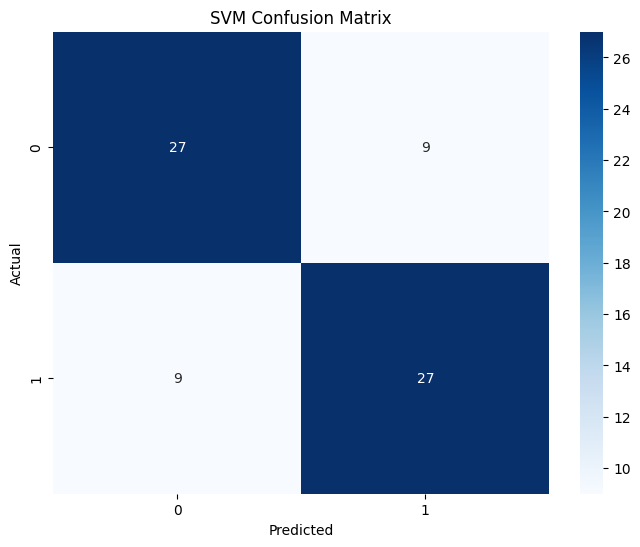

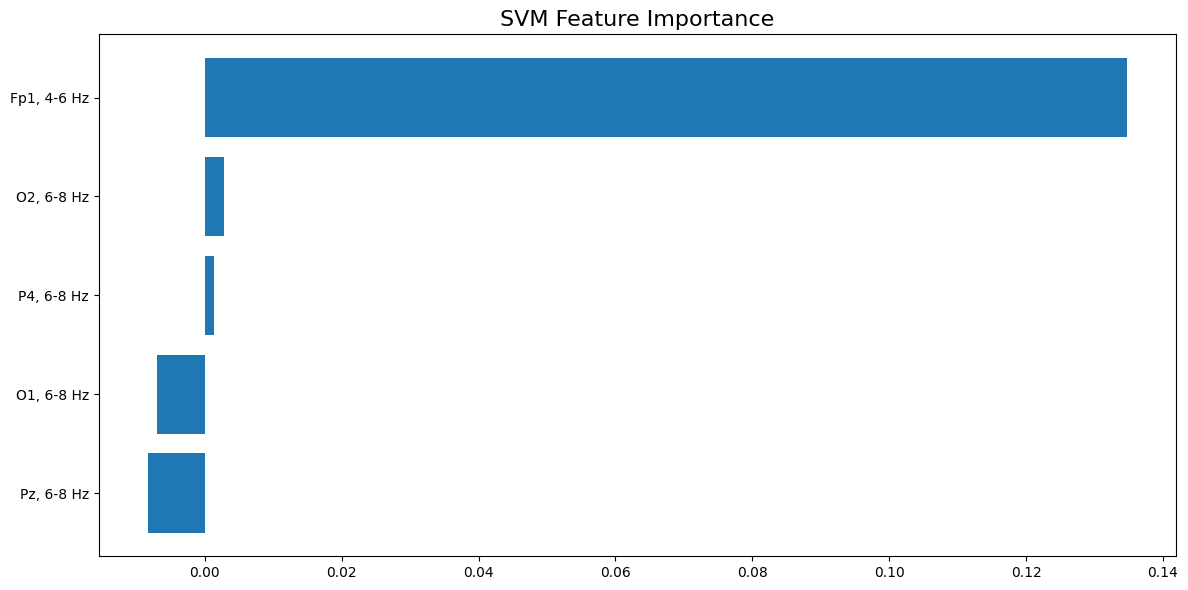

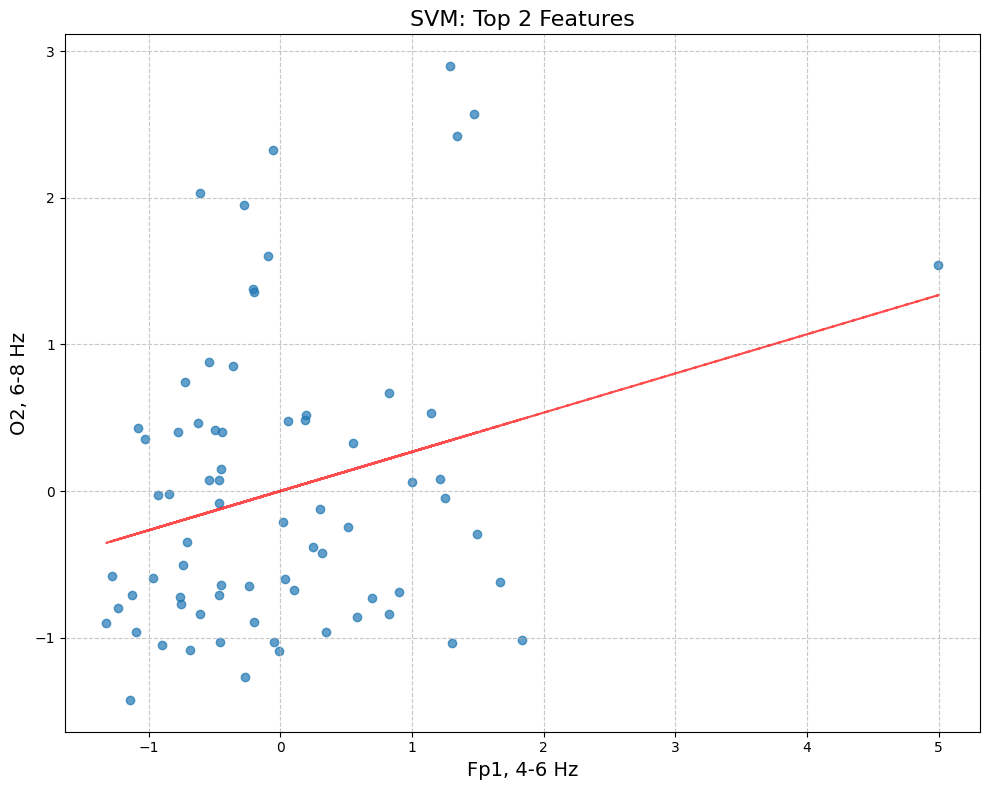

Top feature: Fp1, 4-6 Hz
Second top feature: O2, 6-8 Hz


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

# Utility functions
def select_best_features(X, y, k=5):
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    return X_selected, selected_indices

def evaluate_classifier(X, y, classifier, name, feature_names):
    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')

    print(f"{name} 5-Fold Cross-Validation Results:")
    print(f"Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Fit the model on the entire dataset
    classifier.fit(X, y)

    # Make predictions
    y_pred = classifier.predict(X)

    # Calculate accuracy for the entire dataset
    accuracy = accuracy_score(y, y_pred)
    print(f"\n{name} Accuracy on entire dataset: {accuracy:.4f}")

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y, y_pred, target_names=['No Arithmetic', 'Arithmetic']))

    # Print confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute feature importance
    perm_importance = permutation_importance(classifier, X, y, n_repeats=10, random_state=42)
    feature_importance = perm_importance.importances_mean

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.title(f"{name} Feature Importance", fontsize=16)
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.tight_layout()
    plt.show()

    return classifier, feature_importance

def plot_top_features(X, feature_names, top_indices, classifier_name):
    if len(top_indices) >= 2:
        # Get the top 2 features
        top1_idx = top_indices[0]
        top2_idx = top_indices[1]

        # Extract the feature values
        x_values = X[:, top1_idx]
        y_values = X[:, top2_idx]

        # Create a scatter plot
        plt.figure(figsize=(10, 8))
        plt.scatter(x_values, y_values, alpha=0.7)
        plt.xlabel(feature_names[top1_idx], fontsize=14)
        plt.ylabel(feature_names[top2_idx], fontsize=14)
        plt.title(f"{classifier_name}: Top 2 Features", fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add a trend line
        z = np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        plt.plot(x_values, p(x_values), "r--", alpha=0.7)

        plt.tight_layout()
        plt.show()

        print(f"Top feature: {feature_names[top1_idx]}")
        print(f"Second top feature: {feature_names[top2_idx]}")
    else:
        print("Not enough features to plot")

# Load the data
X = np.load('X_matrix.npy')
y = np.load('y_matrix.npy')
feature_names = np.load('feature_names.npy', allow_pickle=True)

print("Running SVM Classifier...")

# Select the best features
X_selected, selected_indices = select_best_features(X, y, k=5)
print("\nTop 5 features selected for SVM:")
for i in selected_indices:
    print(feature_names[i])

# Create and evaluate the SVM classifier
svm = SVC(kernel='rbf', probability=True, random_state=42)
_, feature_importance = evaluate_classifier(X_selected, y, svm, "SVM", [feature_names[i] for i in selected_indices])

# Sort features by importance
sorted_indices = np.argsort(feature_importance)[::-1]
top_feature_indices = [selected_indices[i] for i in sorted_indices]

# Plot the top 2 features
plot_top_features(X, feature_names, top_feature_indices[:2], "SVM")

***Random Forest Classifier***

Running Random Forest Classifier...

Top 5 features selected for Random Forest:
Fp1, 4-6 Hz
P4, 6-8 Hz
O1, 6-8 Hz
O2, 6-8 Hz
Pz, 6-8 Hz
Random Forest 5-Fold Cross-Validation Results:
Accuracy: 0.6410 (+/- 0.2231)

Random Forest Accuracy on entire dataset: 1.0000

Random Forest Classification Report:
               precision    recall  f1-score   support

No Arithmetic       1.00      1.00      1.00        36
   Arithmetic       1.00      1.00      1.00        36

     accuracy                           1.00        72
    macro avg       1.00      1.00      1.00        72
 weighted avg       1.00      1.00      1.00        72



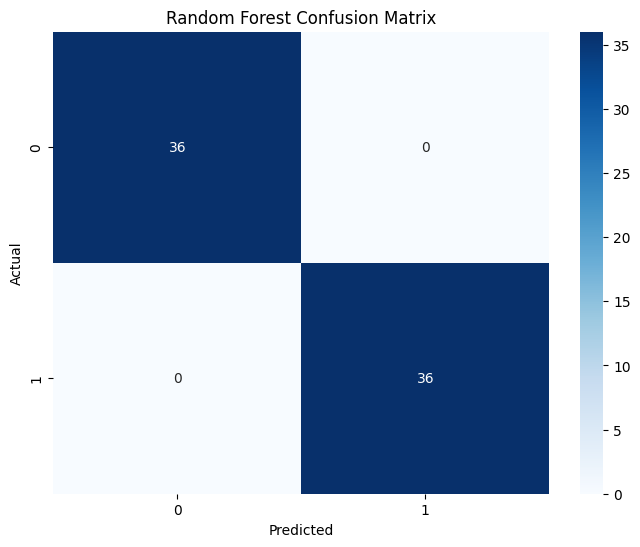

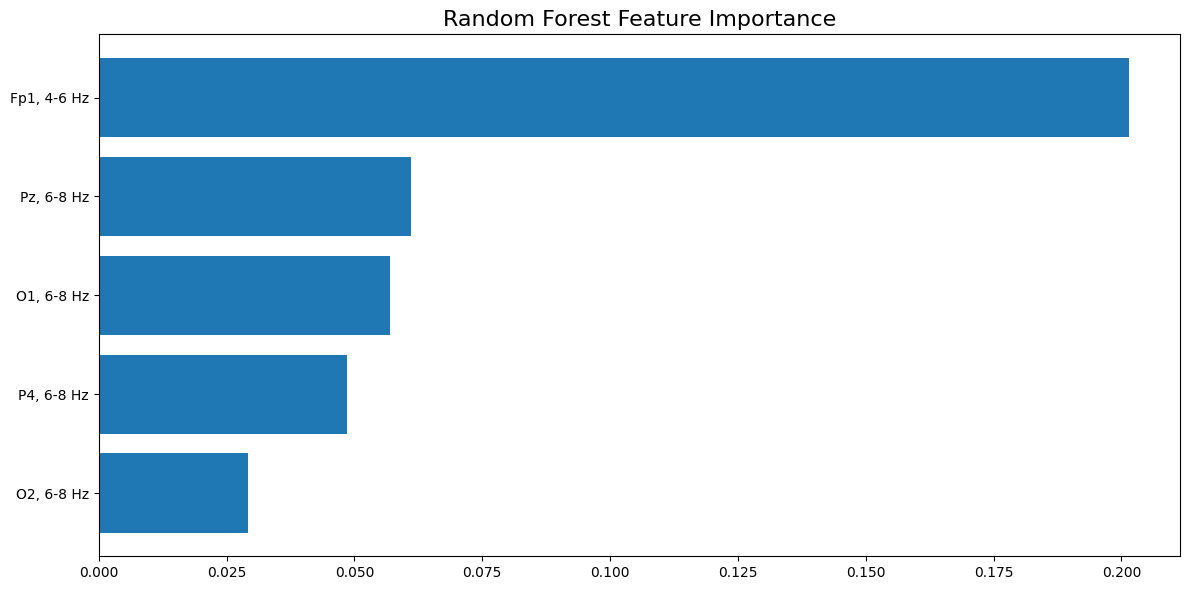

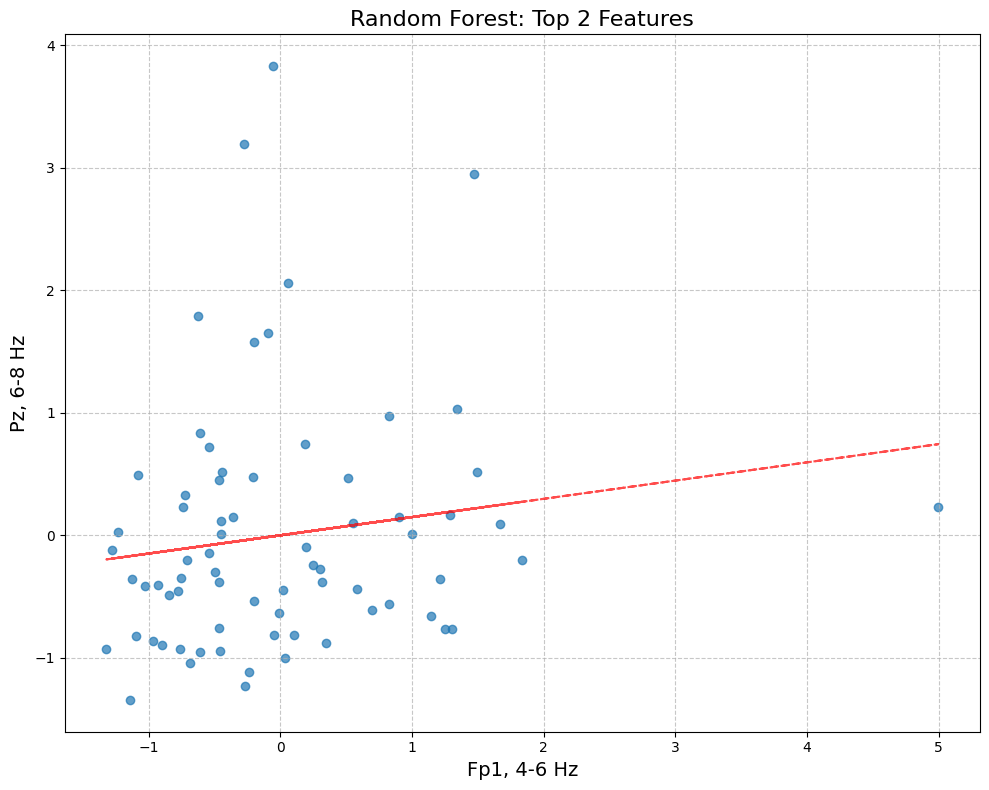

Top feature: Fp1, 4-6 Hz
Second top feature: Pz, 6-8 Hz


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

# Utility functions
def select_best_features(X, y, k=5):
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    return X_selected, selected_indices

def evaluate_classifier(X, y, classifier, name, feature_names):
    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')

    print(f"{name} 5-Fold Cross-Validation Results:")
    print(f"Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Fit the model on the entire dataset
    classifier.fit(X, y)

    # Make predictions
    y_pred = classifier.predict(X)

    # Calculate accuracy for the entire dataset
    accuracy = accuracy_score(y, y_pred)
    print(f"\n{name} Accuracy on entire dataset: {accuracy:.4f}")

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y, y_pred, target_names=['No Arithmetic', 'Arithmetic']))

    # Print confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute feature importance
    perm_importance = permutation_importance(classifier, X, y, n_repeats=10, random_state=42)
    feature_importance = perm_importance.importances_mean

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.title(f"{name} Feature Importance", fontsize=16)
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.tight_layout()
    plt.show()

    return classifier, feature_importance

def plot_top_features(X, feature_names, top_indices, classifier_name):
    if len(top_indices) >= 2:
        # Get the top 2 features
        top1_idx = top_indices[0]
        top2_idx = top_indices[1]

        # Extract the feature values
        x_values = X[:, top1_idx]
        y_values = X[:, top2_idx]

        # Create a scatter plot
        plt.figure(figsize=(10, 8))
        plt.scatter(x_values, y_values, alpha=0.7)
        plt.xlabel(feature_names[top1_idx], fontsize=14)
        plt.ylabel(feature_names[top2_idx], fontsize=14)
        plt.title(f"{classifier_name}: Top 2 Features", fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add a trend line
        z = np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        plt.plot(x_values, p(x_values), "r--", alpha=0.7)

        plt.tight_layout()
        plt.show()

        print(f"Top feature: {feature_names[top1_idx]}")
        print(f"Second top feature: {feature_names[top2_idx]}")
    else:
        print("Not enough features to plot")

# Load the data
X = np.load('X_matrix.npy')
y = np.load('y_matrix.npy')
feature_names = np.load('feature_names.npy', allow_pickle=True)

print("Running Random Forest Classifier...")

# Select the best features
X_selected, selected_indices = select_best_features(X, y, k=5)
print("\nTop 5 features selected for Random Forest:")
for i in selected_indices:
    print(feature_names[i])

# Create and evaluate the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
_, feature_importance = evaluate_classifier(X_selected, y, rf, "Random Forest", [feature_names[i] for i in selected_indices])

# Sort features by importance
sorted_indices = np.argsort(feature_importance)[::-1]
top_feature_indices = [selected_indices[i] for i in sorted_indices]

# Plot the top 2 features
plot_top_features(X, feature_names, top_feature_indices[:2], "Random Forest")

***XGBoost Classifier***

Running XGBoost Classifier...

Top 5 features selected for XGBoost:
Fp1, 4-6 Hz
P4, 6-8 Hz
O1, 6-8 Hz
O2, 6-8 Hz
Pz, 6-8 Hz
XGBoost 5-Fold Cross-Validation Results:
Accuracy: 0.5838 (+/- 0.2284)

XGBoost Accuracy on entire dataset: 1.0000

XGBoost Classification Report:
               precision    recall  f1-score   support

No Arithmetic       1.00      1.00      1.00        36
   Arithmetic       1.00      1.00      1.00        36

     accuracy                           1.00        72
    macro avg       1.00      1.00      1.00        72
 weighted avg       1.00      1.00      1.00        72



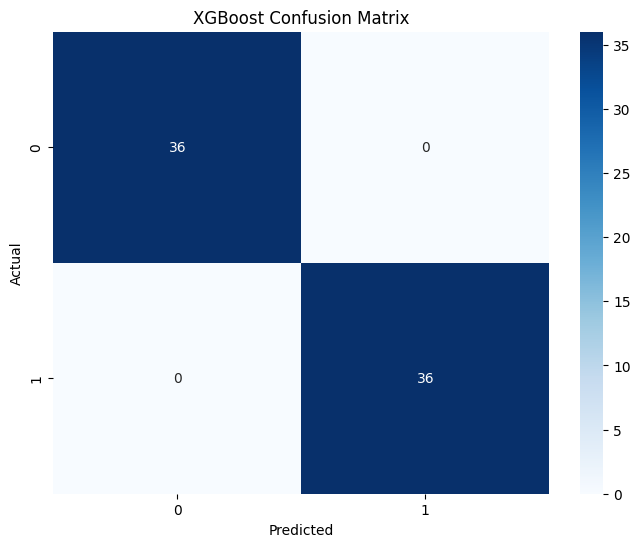

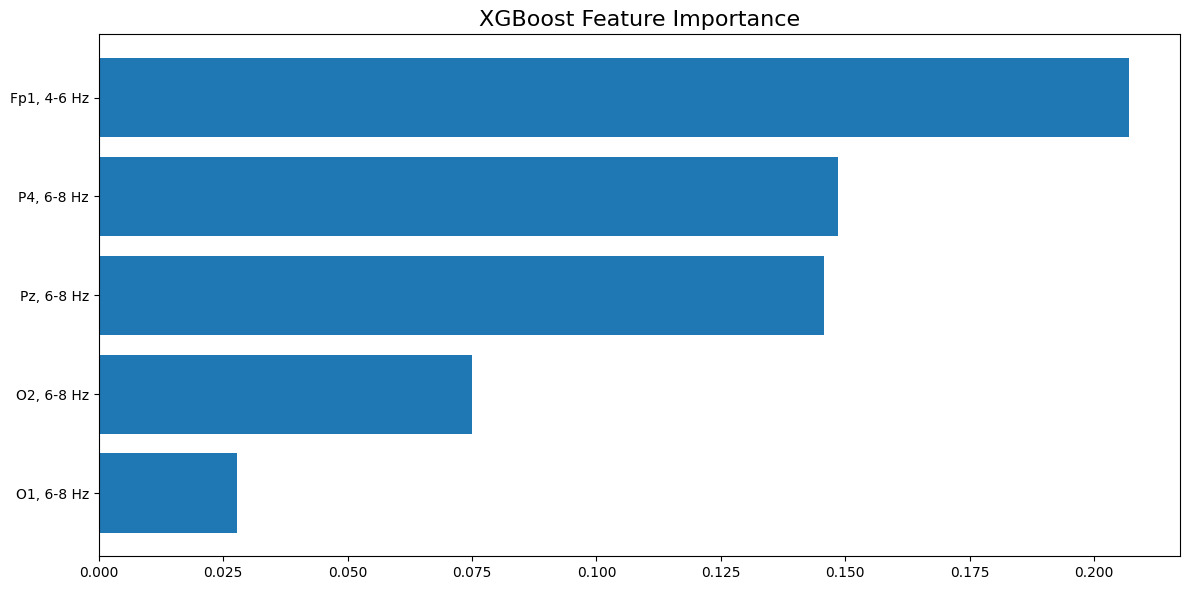

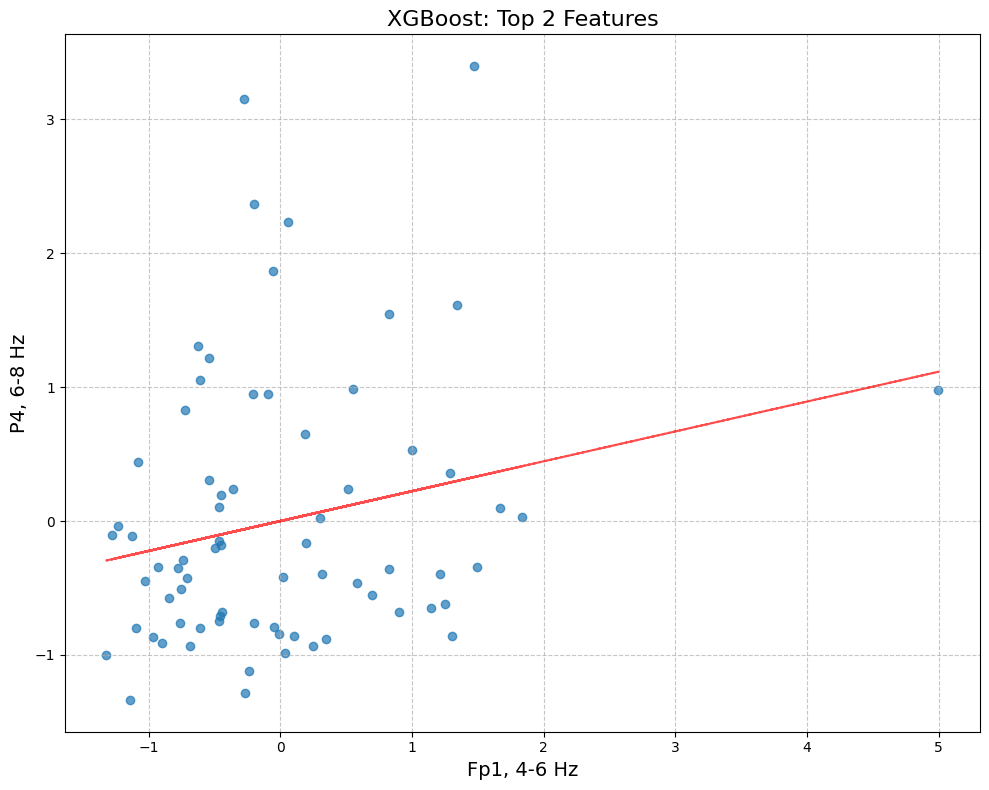

Top feature: Fp1, 4-6 Hz
Second top feature: P4, 6-8 Hz


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

# Utility functions
def select_best_features(X, y, k=5):
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    return X_selected, selected_indices

def evaluate_classifier(X, y, classifier, name, feature_names):
    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')

    print(f"{name} 5-Fold Cross-Validation Results:")
    print(f"Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Fit the model on the entire dataset
    classifier.fit(X, y)

    # Make predictions
    y_pred = classifier.predict(X)

    # Calculate accuracy for the entire dataset
    accuracy = accuracy_score(y, y_pred)
    print(f"\n{name} Accuracy on entire dataset: {accuracy:.4f}")

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y, y_pred, target_names=['No Arithmetic', 'Arithmetic']))

    # Print confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute feature importance
    perm_importance = permutation_importance(classifier, X, y, n_repeats=10, random_state=42)
    feature_importance = perm_importance.importances_mean

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.title(f"{name} Feature Importance", fontsize=16)
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.tight_layout()
    plt.show()

    return classifier, feature_importance

def plot_top_features(X, feature_names, top_indices, classifier_name):
    if len(top_indices) >= 2:
        # Get the top 2 features
        top1_idx = top_indices[0]
        top2_idx = top_indices[1]

        # Extract the feature values
        x_values = X[:, top1_idx]
        y_values = X[:, top2_idx]

        # Create a scatter plot
        plt.figure(figsize=(10, 8))
        plt.scatter(x_values, y_values, alpha=0.7)
        plt.xlabel(feature_names[top1_idx], fontsize=14)
        plt.ylabel(feature_names[top2_idx], fontsize=14)
        plt.title(f"{classifier_name}: Top 2 Features", fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add a trend line
        z = np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        plt.plot(x_values, p(x_values), "r--", alpha=0.7)

        plt.tight_layout()
        plt.show()

        print(f"Top feature: {feature_names[top1_idx]}")
        print(f"Second top feature: {feature_names[top2_idx]}")
    else:
        print("Not enough features to plot")

# Load the data
X = np.load('X_matrix.npy')
y = np.load('y_matrix.npy')
feature_names = np.load('feature_names.npy', allow_pickle=True)

print("Running XGBoost Classifier...")

# Select the best features
X_selected, selected_indices = select_best_features(X, y, k=5)
print("\nTop 5 features selected for XGBoost:")
for i in selected_indices:
    print(feature_names[i])

# Create and evaluate the XGBoost classifier
xgb = XGBClassifier(random_state=42)
_, feature_importance = evaluate_classifier(X_selected, y, xgb, "XGBoost", [feature_names[i] for i in selected_indices])

# Sort features by importance
sorted_indices = np.argsort(feature_importance)[::-1]
top_feature_indices = [selected_indices[i] for i in sorted_indices]

# Plot the top 2 features
plot_top_features(X, feature_names, top_feature_indices[:2], "XGBoost")

***Logistic Regression***

Running Logistic Regression Classifier...

Top 5 features selected for Logistic Regression:
Fp1, 4-6 Hz
P4, 6-8 Hz
O1, 6-8 Hz
O2, 6-8 Hz
Pz, 6-8 Hz
Logistic Regression 5-Fold Cross-Validation Results:
Accuracy: 0.7105 (+/- 0.2633)

Logistic Regression Accuracy on entire dataset: 0.7500

Logistic Regression Classification Report:
               precision    recall  f1-score   support

No Arithmetic       0.75      0.75      0.75        36
   Arithmetic       0.75      0.75      0.75        36

     accuracy                           0.75        72
    macro avg       0.75      0.75      0.75        72
 weighted avg       0.75      0.75      0.75        72



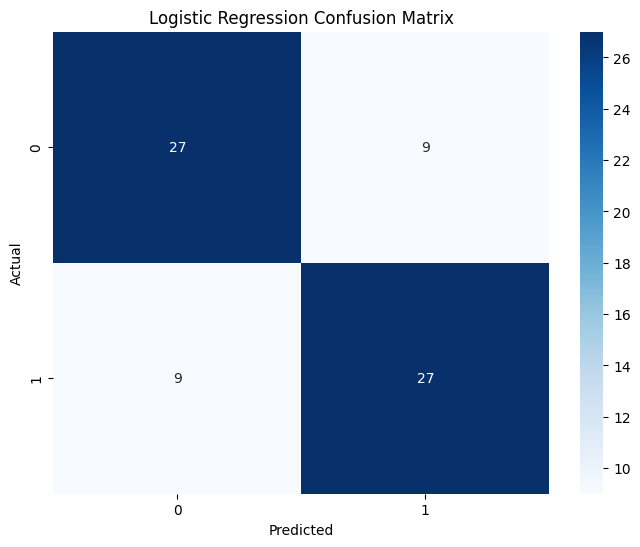

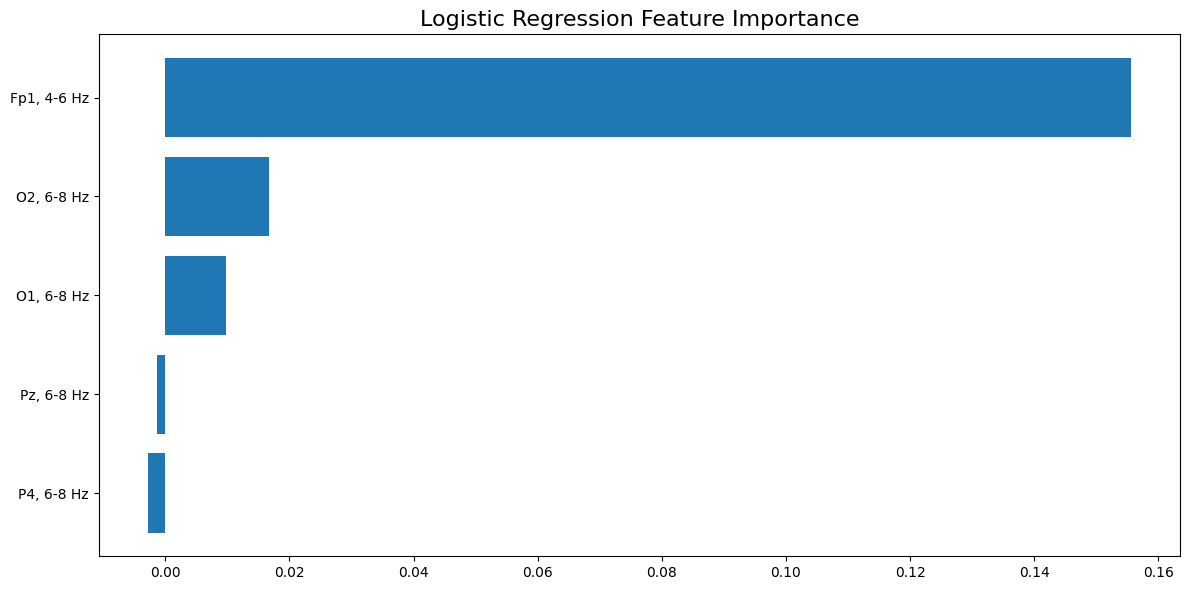

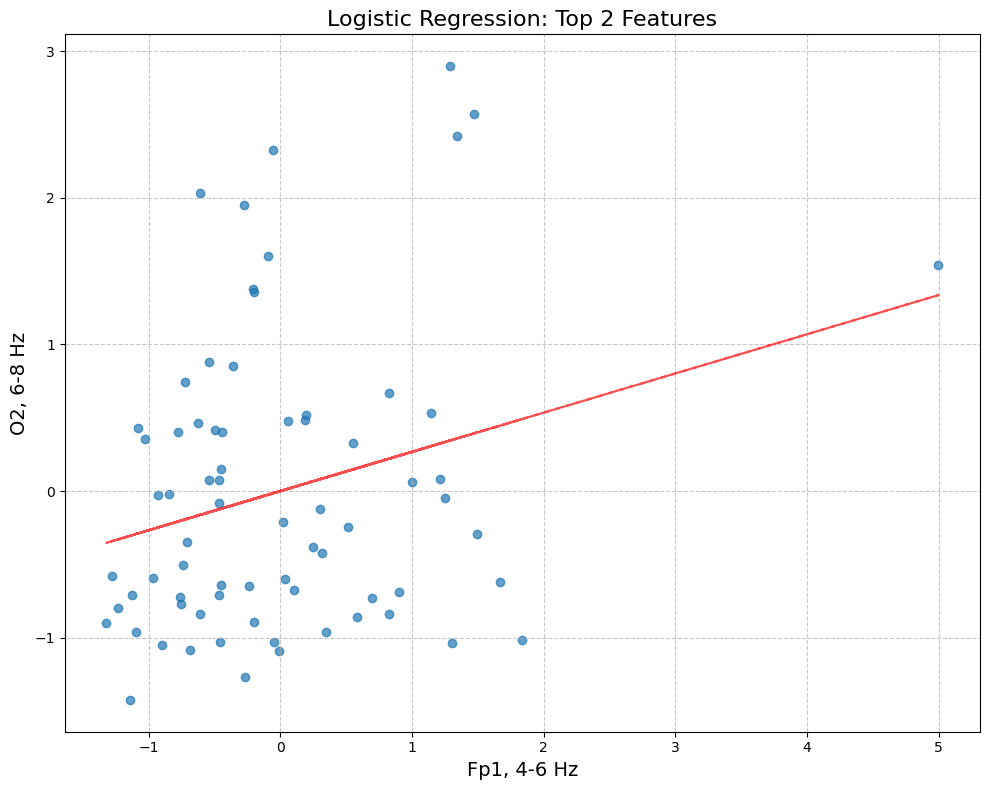

Top feature: Fp1, 4-6 Hz
Second top feature: O2, 6-8 Hz


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

# Utility functions
def select_best_features(X, y, k=5):
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    return X_selected, selected_indices

def evaluate_classifier(X, y, classifier, name, feature_names):
    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')

    print(f"{name} 5-Fold Cross-Validation Results:")
    print(f"Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Fit the model on the entire dataset
    classifier.fit(X, y)

    # Make predictions
    y_pred = classifier.predict(X)

    # Calculate accuracy for the entire dataset
    accuracy = accuracy_score(y, y_pred)
    print(f"\n{name} Accuracy on entire dataset: {accuracy:.4f}")

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y, y_pred, target_names=['No Arithmetic', 'Arithmetic']))

    # Print confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute feature importance
    perm_importance = permutation_importance(classifier, X, y, n_repeats=10, random_state=42)
    feature_importance = perm_importance.importances_mean

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.title(f"{name} Feature Importance", fontsize=16)
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.tight_layout()
    plt.show()

    return classifier, feature_importance

def plot_top_features(X, feature_names, top_indices, classifier_name):
    if len(top_indices) >= 2:
        # Get the top 2 features
        top1_idx = top_indices[0]
        top2_idx = top_indices[1]

        # Extract the feature values
        x_values = X[:, top1_idx]
        y_values = X[:, top2_idx]

        # Create a scatter plot
        plt.figure(figsize=(10, 8))
        plt.scatter(x_values, y_values, alpha=0.7)
        plt.xlabel(feature_names[top1_idx], fontsize=14)
        plt.ylabel(feature_names[top2_idx], fontsize=14)
        plt.title(f"{classifier_name}: Top 2 Features", fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add a trend line
        z = np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        plt.plot(x_values, p(x_values), "r--", alpha=0.7)

        plt.tight_layout()
        plt.show()

        print(f"Top feature: {feature_names[top1_idx]}")
        print(f"Second top feature: {feature_names[top2_idx]}")
    else:
        print("Not enough features to plot")

# Load the data
X = np.load('X_matrix.npy')
y = np.load('y_matrix.npy')
feature_names = np.load('feature_names.npy', allow_pickle=True)

print("Running Logistic Regression Classifier...")
# Note: Using Logistic Regression instead of Linear Regression since this is a classification task

# Select the best features
X_selected, selected_indices = select_best_features(X, y, k=5)
print("\nTop 5 features selected for Logistic Regression:")
for i in selected_indices:
    print(feature_names[i])

# Create and evaluate the Logistic Regression classifier
lr = LogisticRegression(random_state=42, max_iter=1000)
_, feature_importance = evaluate_classifier(X_selected, y, lr, "Logistic Regression", [feature_names[i] for i in selected_indices])

# Sort features by importance
sorted_indices = np.argsort(feature_importance)[::-1]
top_feature_indices = [selected_indices[i] for i in sorted_indices]

# Plot the top 2 features
plot_top_features(X, feature_names, top_feature_indices[:2], "Logistic Regression")

***Combined Analysis***

Running Combined Analysis...

Top 5 features selected across all classifiers:
Fp1, 4-6 Hz
P4, 6-8 Hz
O1, 6-8 Hz
O2, 6-8 Hz
Pz, 6-8 Hz

Calculating feature importance for KNN...

Calculating feature importance for SVM...

Calculating feature importance for Random Forest...

Calculating feature importance for Logistic Regression...

Calculating feature importance for XGBoost...


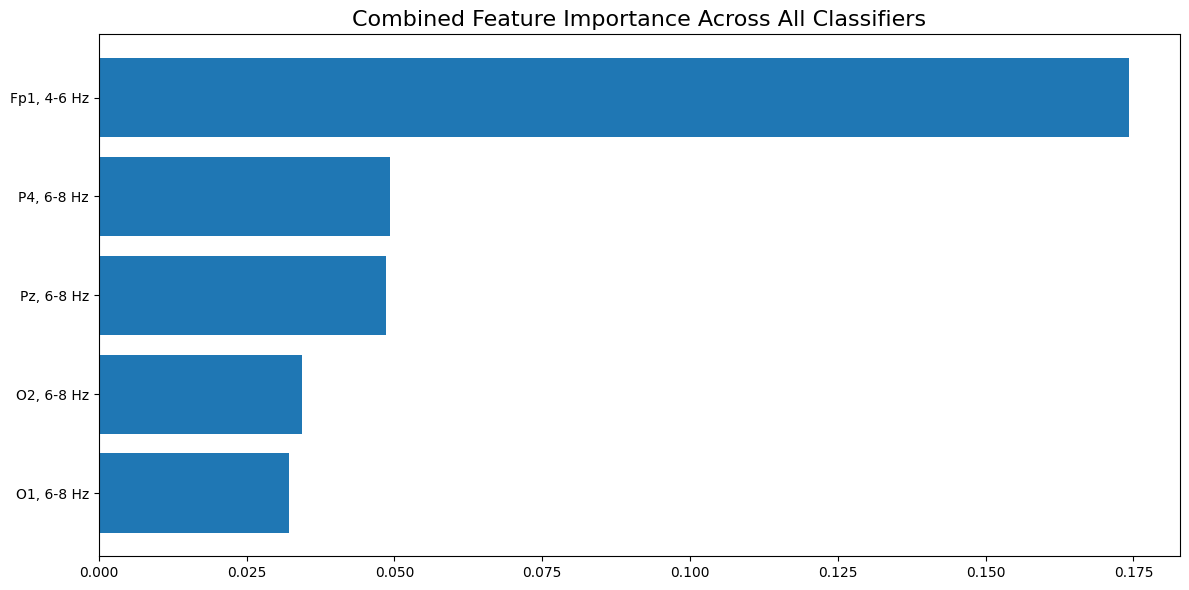


Top 2 most important features across all classifiers:
1. Fp1, 4-6 Hz
2. P4, 6-8 Hz


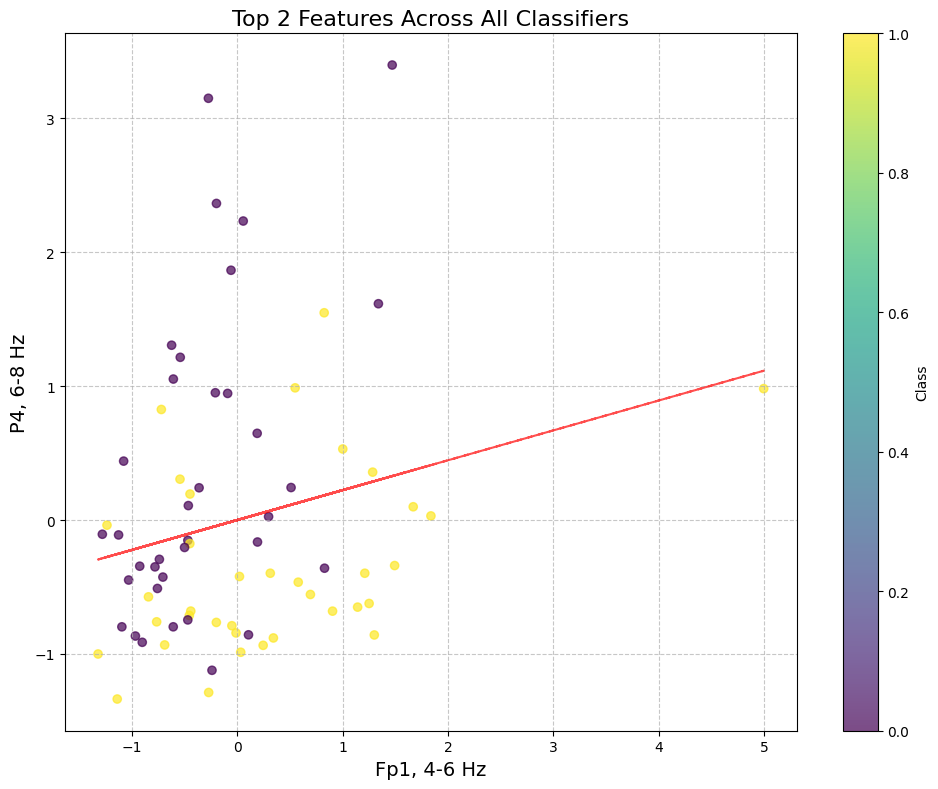

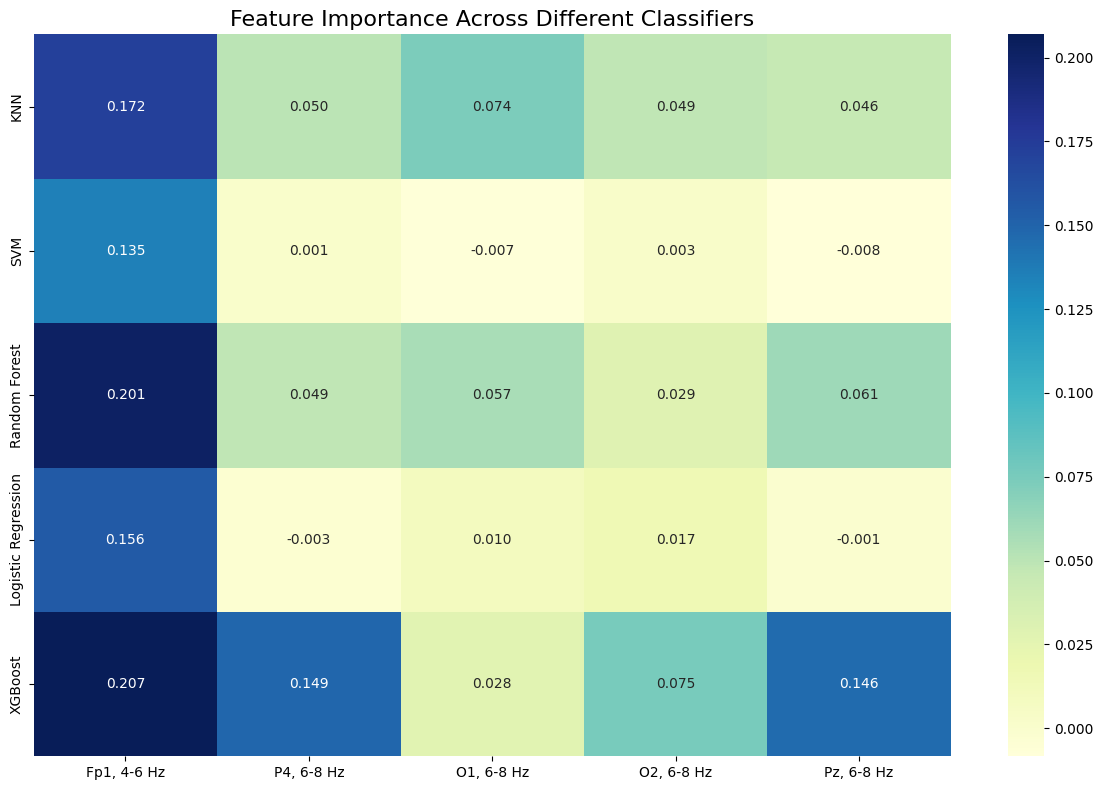

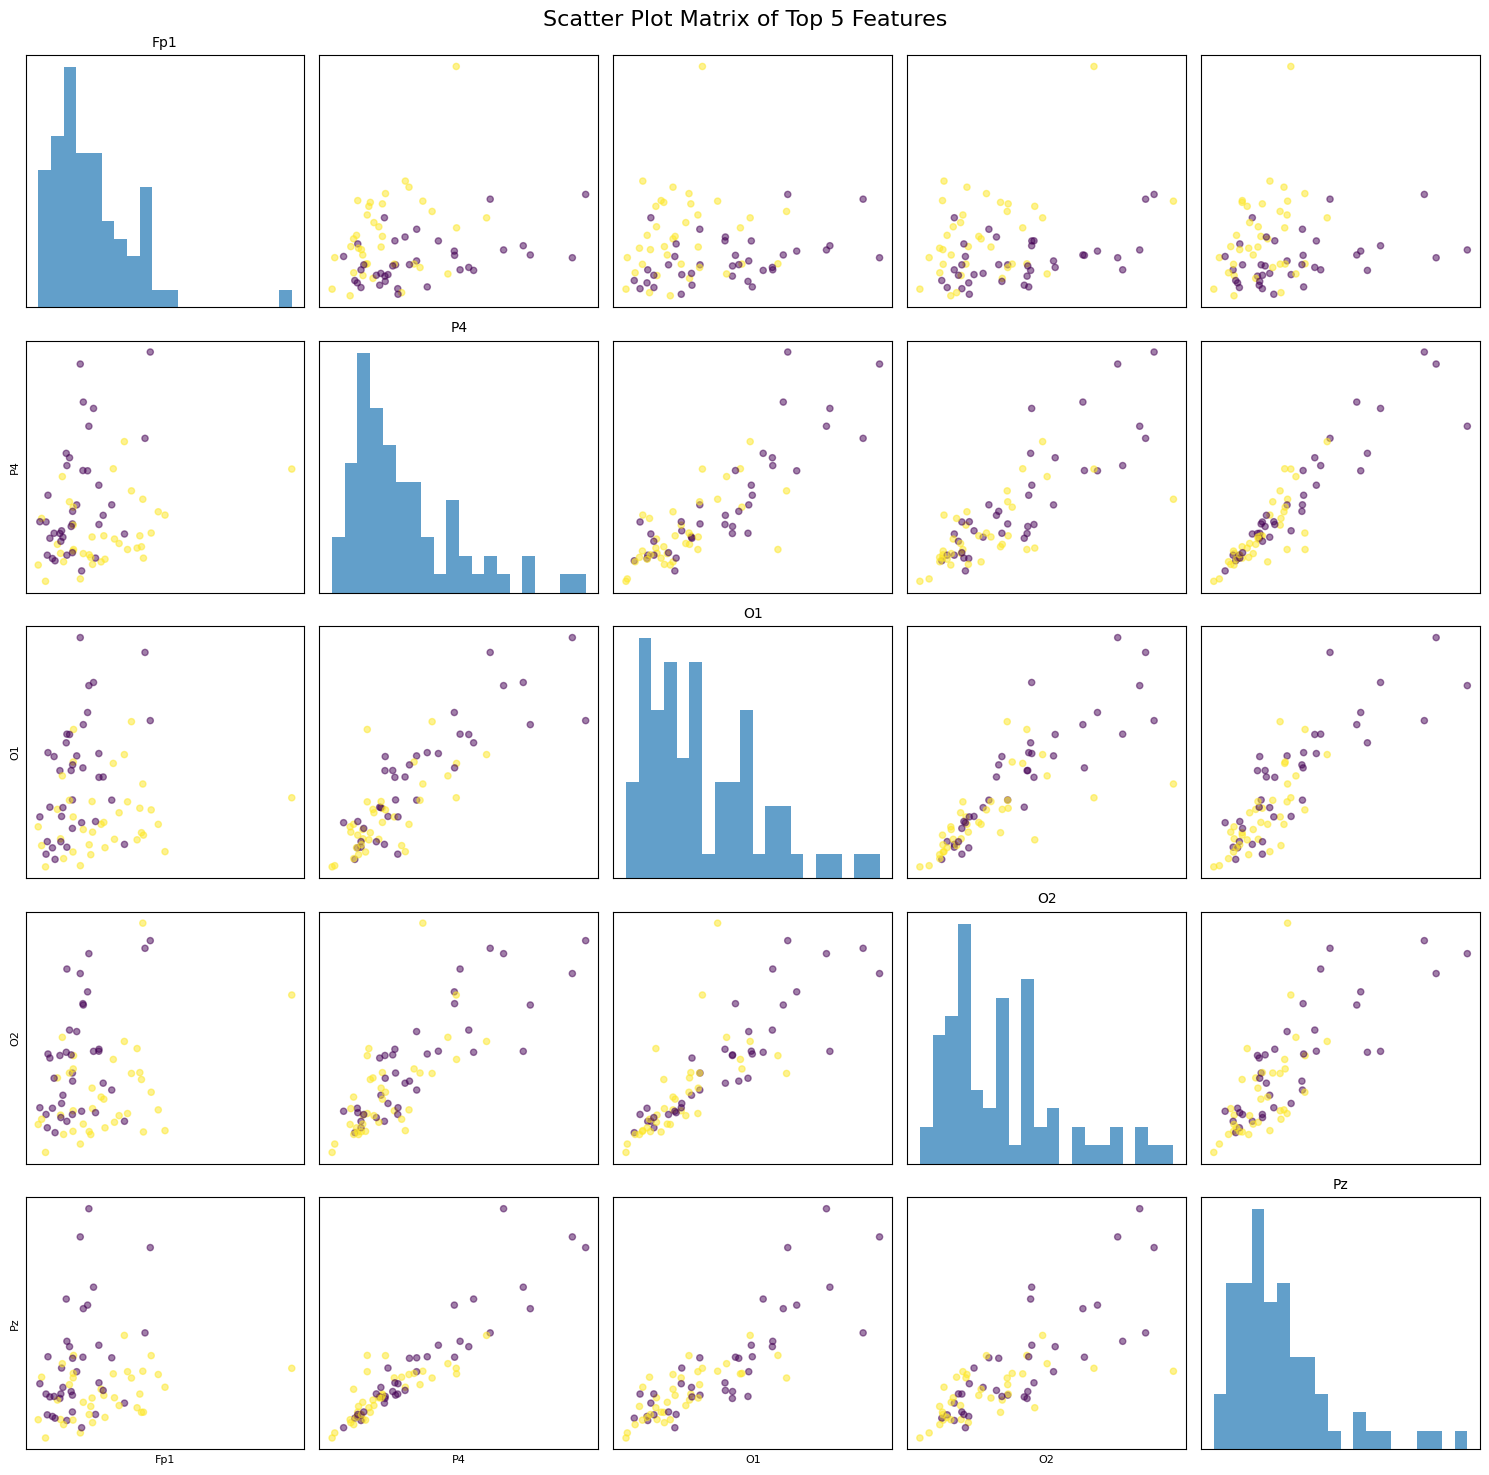

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

# Utility function
def select_best_features(X, y, k=5):
    selector = SelectKBest(f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    return X_selected, selected_indices

# Load the data
X = np.load('X_matrix.npy')
y = np.load('y_matrix.npy')
feature_names = np.load('feature_names.npy', allow_pickle=True)

print("Running Combined Analysis...")

# Select the best features
X_selected, selected_indices = select_best_features(X, y, k=5)
selected_feature_names = [feature_names[i] for i in selected_indices]

print("\nTop 5 features selected across all classifiers:")
for i in selected_indices:
    print(feature_names[i])

# Create classifiers
classifiers = [
    (KNeighborsClassifier(n_neighbors=5), "KNN"),
    (SVC(kernel='rbf', probability=True, random_state=42), "SVM"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (LogisticRegression(random_state=42, max_iter=1000), "Logistic Regression"),
    (XGBClassifier(random_state=42), "XGBoost")
]

# Calculate feature importance for each classifier
all_importances = []
for classifier, name in classifiers:
    print(f"\nCalculating feature importance for {name}...")
    classifier.fit(X_selected, y)
    perm_importance = permutation_importance(classifier, X_selected, y, n_repeats=10, random_state=42)
    all_importances.append(perm_importance.importances_mean)

# Average importance across all classifiers
combined_importance = np.mean(all_importances, axis=0)

# Plot combined feature importance
plt.figure(figsize=(12, 6))
plt.title("Combined Feature Importance Across All Classifiers", fontsize=16)
sorted_idx = np.argsort(combined_importance)
plt.barh(range(len(sorted_idx)), combined_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [selected_feature_names[i] for i in sorted_idx])
plt.tight_layout()
plt.show()

# Get the top 2 most important features
top_indices = np.argsort(combined_importance)[::-1][:2]
top_feature_indices = [selected_indices[i] for i in top_indices]

print("\nTop 2 most important features across all classifiers:")
print(f"1. {feature_names[top_feature_indices[0]]}")
print(f"2. {feature_names[top_feature_indices[1]]}")

# Plot the top 2 features
plt.figure(figsize=(10, 8))
plt.scatter(X[:, top_feature_indices[0]], X[:, top_feature_indices[1]], c=y, cmap='viridis', alpha=0.7)
plt.xlabel(feature_names[top_feature_indices[0]], fontsize=14)
plt.ylabel(feature_names[top_feature_indices[1]], fontsize=14)
plt.title("Top 2 Features Across All Classifiers", fontsize=16)
plt.colorbar(label='Class')
plt.grid(True, linestyle='--', alpha=0.7)

# Add a trend line
z = np.polyfit(X[:, top_feature_indices[0]], X[:, top_feature_indices[1]], 1)
p = np.poly1d(z)
plt.plot(X[:, top_feature_indices[0]], p(X[:, top_feature_indices[0]]), "r--", alpha=0.7)

plt.tight_layout()
plt.show()

# Create a heatmap of feature importance across classifiers
plt.figure(figsize=(12, 8))
importance_df = np.array(all_importances)
sns.heatmap(importance_df, annot=True, fmt=".3f", cmap="YlGnBu",
            xticklabels=selected_feature_names,
            yticklabels=[name for _, name in classifiers])
plt.title("Feature Importance Across Different Classifiers", fontsize=16)
plt.tight_layout()
plt.show()

# Create a scatter plot matrix of the top 5 features
plt.figure(figsize=(15, 15))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5 + j + 1)
        if i == j:
            # Histogram on the diagonal
            plt.hist(X[:, selected_indices[i]], bins=20, alpha=0.7)
            plt.title(selected_feature_names[i].split(',')[0], fontsize=10)
        else:
            # Scatter plot on the off-diagonal
            plt.scatter(X[:, selected_indices[j]], X[:, selected_indices[i]], c=y, alpha=0.5, s=20)
            if i == 4:  # Bottom row
                plt.xlabel(selected_feature_names[j].split(',')[0], fontsize=8)
            if j == 0:  # Leftmost column
                plt.ylabel(selected_feature_names[i].split(',')[0], fontsize=8)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.suptitle("Scatter Plot Matrix of Top 5 Features", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()